In [1]:
import sys
import os
sys.path.append('../')
from models.dino_encoder import ImageEncoder
from models.program_encoder import CLEVRTexProgramEncoder, MoviProgramEncoder, COCOProgramEncoder
from dataset_loader.clevrtex_dataset import CLEVrTexProgramDataSet  
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torch
from matplotlib import pyplot as plt

#reload modules
%load_ext autoreload
%autoreload 2

In [2]:
class Args:

    num_blocks = 8
    image_size = 224
    d_model = 192
    hidden_dim = 192
    num_heads = 8
    dropout = 0.1
    num_iterations = 3
    num_slots = 11
    num_slot_heads = 1
    slot_dim = 192
    embed_dim = 64
    mlp_hidden_size = 192
    max_program_len = 10

args = Args()

In [3]:
def display_image(image):
    '''
    convert tensor to image and display
    '''
    image = image.permute(1,2,0)
    image = image.cpu().numpy()
    plt.axis('off')
    #no padding
    plt.tight_layout(pad=0)
    plt.imshow(image)
    plt.show()

In [4]:
transform = transforms.Compose(
        [
            transforms.Resize(args.image_size,interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(args.image_size),
        ]
)


data_path = '../datasets/clevrtex/'
val_dataset = CLEVrTexProgramDataSet(data_path, 'val', transform, max_program_len=args.max_program_len)
val_sampler = None

def __collate_fn(batch):
    imgs, labels, lengths = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    labels = torch.stack(labels, dim=0)
    lengths = torch.stack(lengths)
    return imgs, labels, lengths

loader_kwargs = {
    'batch_size': 16,
    'shuffle': False,
    'num_workers': 1,
    'pin_memory': True,
    'drop_last': True,
}


val_loader = DataLoader(val_dataset, sampler=val_sampler, collate_fn = __collate_fn, **loader_kwargs)

In [5]:
#load models
model_path = '../logs/clevrtex/NSI/best_model.pt'

slot_encoder = ImageEncoder(args)
program_encoder = CLEVRTexProgramEncoder(args.num_blocks, args.d_model, args.num_heads, args.embed_dim, dropout=args.dropout)

checkpoint = torch.load(model_path)
slot_encoder.load_state_dict(checkpoint['slot_encoder'])
program_encoder.load_state_dict(checkpoint['program_encoder'])
slot_encoder = slot_encoder.cuda()
program_encoder = program_encoder.cuda()

In [6]:
imgs, labels, lengths = next(iter(val_loader))
imgs = imgs.cuda()

slot_encoder.eval()
with torch.no_grad():
    slot_proj, attns_vis, attns_raw, slots, mse_loss = slot_encoder(imgs)

/home/bdedhia/.conda/envs/txf_design-space/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 127.5, 2077.5, -0.5)

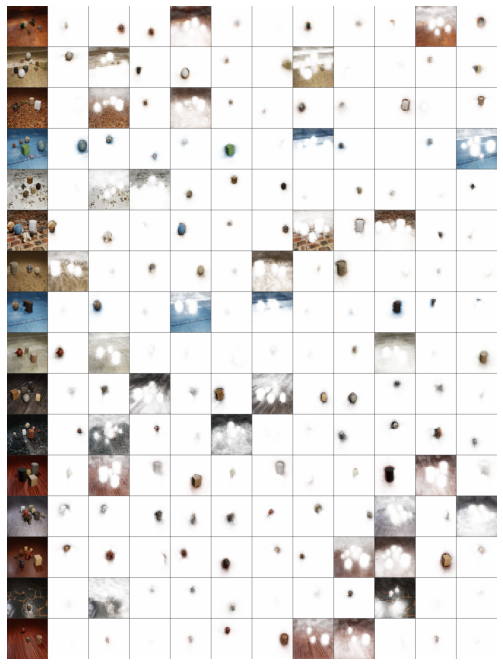

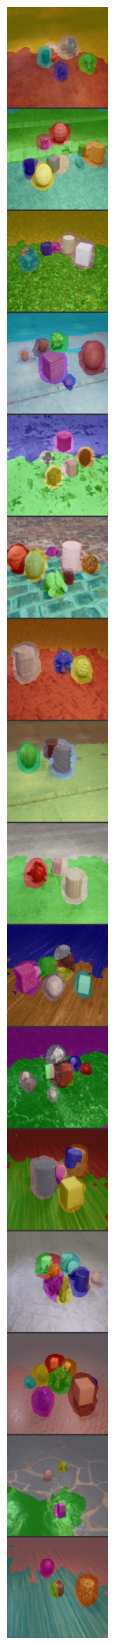

In [7]:
color = {
    'red': torch.tensor([1, 0, 0]),
    'green': torch.tensor([0, 1, 0]),
    'blue': torch.tensor([0, 0, 1]),
    'yellow': torch.tensor([1, 1, 0]),
    'magenta': torch.tensor([1, 0, 1]),
    'orange': torch.tensor([1, 0.5, 0]),
    'cyan': torch.tensor([0, 1, 1]),
    # 'lime': torch.tensor([0.5, 1, 0]),
    'pink': torch.tensor([1, 0.75, 0.8]),
    # 'teal': torch.tensor([0, 0.5, 0.5]),
    'lavender': torch.tensor([0.9, 0.9, 0.98]),
    'brown': torch.tensor([0.65, 0.16, 0.16]),
    'beige': torch.tensor([0.96, 0.96, 0.86]),
    'maroon': torch.tensor([0.5, 0, 0]),
    'mint': torch.tensor([0.24, 0.71, 0.54]),
    'olive': torch.tensor([0.5, 0.5, 0]),
    'apricot': torch.tensor([0.98, 0.81, 0.69]),
}
color_list = list(color.values())

def visualize(image, attns, N=8):

    _, _, H, W = image.shape
    image = image[:N].unsqueeze(dim=1)
    attns = attns[:N].expand(-1, -1, 3, H, W)

    return torch.cat((image, attns), dim=1).view(-1, 3, H, W)

def visualize_with_unweighted_alpha_masks(image, attns_raw, N=8, opacity=0.0):
    '''
    overlay alpha masks on image with distinct colors
    '''

    _, _, H, W = image.shape
    image = image[:N]
    #reduce image resolution by a factor of 8
    image = torch.nn.functional.interpolate(image, size=(128, 128), mode='bilinear', align_corners=False)
    assignment = attns_raw[:N].squeeze(dim=2)
    assignment = torch.nn.functional.interpolate(assignment, size=(128, 128), mode='bilinear', align_corners=False)
    assignment = assignment.argmax(dim=1) # (N, H, W)
    assignment = assignment.unsqueeze(dim=1)
    alpha_masks = torch.zeros_like(image).cpu()
    # for each color, assign alpha mask using assignment
    for i in range(args.num_slots):
        mask = (assignment == i).expand(-1, 3, -1, -1).cpu().float()
        #assign color to alpha mask
        alpha_masks += mask * color_list[i][None, :, None, None]
    base_image = image.cpu().float()
    overlay =base_image*(1 - opacity) + alpha_masks * opacity
    return overlay




slots_vis = visualize(imgs, attns_vis,N=16)
overlay = visualize_with_unweighted_alpha_masks(imgs, attns_raw,N=16,opacity=0.35)

grid = utils.make_grid(slots_vis, nrow=args.num_slots + 1, pad_value=0.2)[:, 2:-2, 2:-2]
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')

grid = utils.make_grid(overlay, nrow= 1, pad_value=0.2)[:, 2:-2, 2:-2]
plt.figure(figsize=(60,30))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


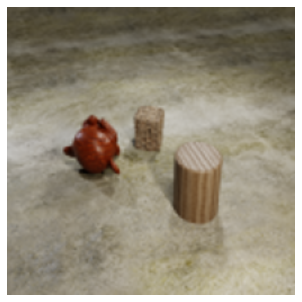

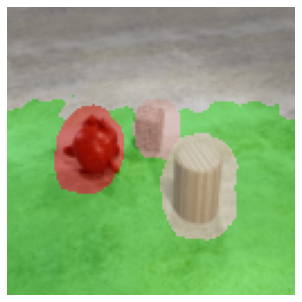

In [8]:
display_image(imgs[8])
display_image(overlay[8])

In [9]:
#now encode the program
program_encoder.eval()
labels = labels.cuda()
program_proj, _ = program_encoder(labels)


In [10]:
#finding slot program alignment now
sim = torch.einsum('bse,bte->bst', slot_proj, program_proj)
alignment = torch.argmax(sim, dim=1)
alignment_score = torch.max(sim, dim=1).values

In [29]:
import json
with open('../datasets/clevrtex/label2program.json') as f:
    label2program = json.load(f)

def print_out(labels):
    str_program = '<size>' + label2program['sizes'][str(int(labels[0]))] + '</size> \n'
    str_program += '<shape> '+ label2program['shapes'][str(int(labels[1]))] + '</shape>\n'
    str_program += '<material> '+ label2program['materials'][str(int(labels[2]))] + '</material>\n'
    str_program += f'<pos> ({labels[3]}, {labels[4]},{labels[5]}) </pos>'
    return str_program

overall alignment score 33.56098556518555
slot id 3
alignment score 9.988765716552734
<size>large</size> 
<shape> monkey</shape>
<material> polyhaven_wood_floor_deck</material>
<pos> (-0.2811421751976013, -1.975210189819336,0.8999999761581421) </pos>


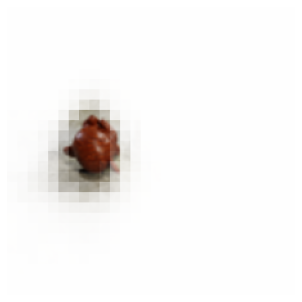

slot id 5
alignment score 7.561081886291504
<size>medium</size> 
<shape> cube</shape>
<material> polyhaven_red_sandstone_wall</material>
<pos> (-0.353839248418808, 0.23363880813121796,0.4242640733718872) </pos>


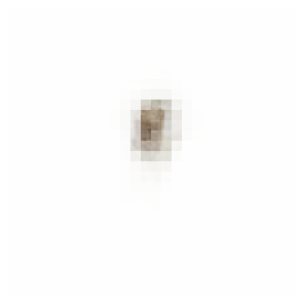

slot id 7
alignment score 16.011138916015625
<size>medium</size> 
<shape> cylinder</shape>
<material> polyhaven_kitchen_wood</material>
<pos> (2.584441661834717, -0.6463373303413391,0.6000000238418579) </pos>


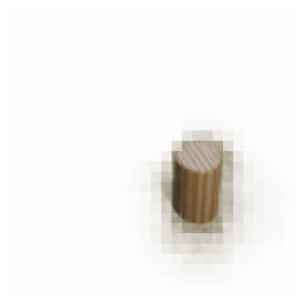

In [30]:
B = labels.shape[0]

for b in range(8,9):
    labels_this = labels[b]
    lengths_this = lengths[b]
    alignment_this = alignment[b,:lengths_this]
    alignment_score_this = alignment_score[b,:lengths_this]
    print('overall alignment score', torch.sum(alignment_score_this).item())
    attns_vis_this = attns_vis[b]
    for i, slot_id in enumerate(alignment_this):
        print('slot id', slot_id.item())
        attns_aligned = attns_vis_this[slot_id]
        print('alignment score', alignment_score_this[i].item())
        print(print_out(labels_this[i].cpu().numpy().tolist()))
        display_image(attns_aligned)


In [11]:
import numpy as np
import h5py as h5
path_topk_images = '../logs/clevrtex/retrieval/NSI/sorted_images_3.npy'
path_topk_programs = '../logs/clevrtex/retrieval/NSI/sorted_programs_3.npy'
#load images
topk_images = np.load(path_topk_images, allow_pickle=True)
topk_programs = np.load(path_topk_programs, allow_pickle=True)

with h5.File('../datasets/clevrtex/images.h5', 'r') as f:
    images = f['val'][:]


[   8 1447 6287 2192 3655]


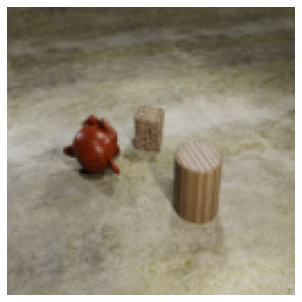

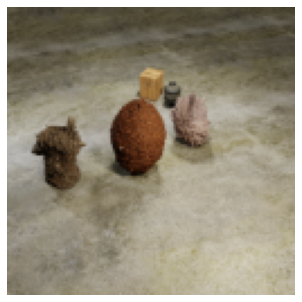

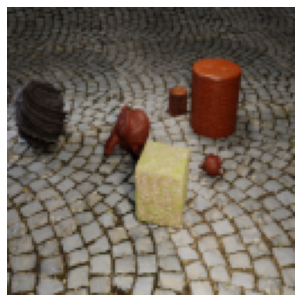

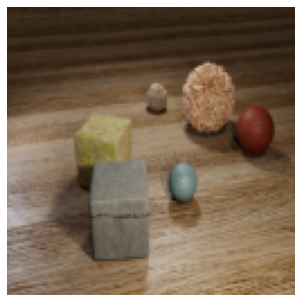

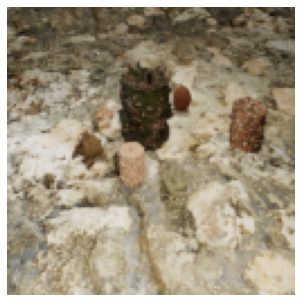

In [12]:
topk_rank = topk_programs[8][:5]
print(topk_rank)
#display the topk images
for i in topk_rank:
    display_image(torch.tensor(images[i]).permute(2,0,1))


In [23]:

#calculate alignment score for each image
input_images = torch.tensor(images[topk_rank]).permute(0,3,1,2).cuda().float()
#apply transformations
input_images = transform(input_images)
with torch.no_grad():
    slot_proj_sim, _, _, _, _ = slot_encoder(input_images)
program_proj_expanded = program_proj[8,:lengths[8]].unsqueeze(0).expand(5,-1,-1)
sim = torch.einsum('bse,bte->bst', slot_proj_sim, program_proj_expanded)
alignment_score = torch.max(sim, dim=1).values
print(torch.sum(alignment_score, dim=1))


/home/bdedhia/.conda/envs/txf_design-space/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([ 33.5279, -57.7421, -42.4195, -37.8583, -33.9005], device='cuda:0',
       grad_fn=<SumBackward1>)
